<a href="https://colab.research.google.com/github/sergioberdiales/TFM_KSchool_Gijon_Air_Pollution/blob/master/22_Forecasting_Models_ML_PM10_MULTIVAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are going to try to improve the autoregressive forecasting models introducing more variables.
We will use the XGBoost algorithm. 

In [0]:
%pylab inline
import pandas as pd

# We install and import pyreadr, in order to read rds objects.  
# https://github.com/ofajardo/pyreadr

!pip install pyreadr
import pyreadr


# Importing models


import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Importing metrics

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Model selection
from sklearn.model_selection import GridSearchCV

# Variable selection

import sklearn
from sklearn.feature_selection import f_regression


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


We upload the train and test data. All rds files from this folder  ~\`TFM_KSchool_Gijon_Air_Pollution\train_test\
Forecasting_Models_ML_PM10_MULTIVAR

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving X_test_PM10_201701_201709_multivar.rds to X_test_PM10_201701_201709_multivar.rds
Saving X_test_PM10_20170101_20170114_multivar.rds to X_test_PM10_20170101_20170114_multivar.rds
Saving X_train_PM10_200901_201612_multivar.rds to X_train_PM10_200901_201612_multivar.rds
Saving X_train_PM10_201401_201612_multivar.rds to X_train_PM10_201401_201612_multivar.rds
Saving X_train_PM10_201610_201612_multivar.rds to X_train_PM10_201610_201612_multivar.rds
Saving X_validation_PM10_201710_201712_multivar.rds to X_validation_PM10_201710_201712_multivar.rds
Saving y_test_PM10_201701_201709_multivar.rds to y_test_PM10_201701_201709_multivar.rds
Saving y_test_PM10_20170101_20170114_multivar.rds to y_test_PM10_20170101_20170114_multivar.rds
Saving y_train_PM10_200901_201612_multivar.rds to y_train_PM10_200901_201612_multivar.rds
Saving y_train_PM10_201401_201612_multivar.rds to y_train_PM10_201401_201612_multivar.rds
Saving y_train_PM10_201610_201612_multivar.rds to y_train_PM10_201610_201612_multi

In [0]:
!ls

sample_data


In [0]:
# !rm *

rm: cannot remove 'sample_data': Is a directory


In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]


X_train.head()



,no_lab_days,hour,week_day,month,PM10_1,PM10_2,PM10_3,PM10_4,PM10_5,PM10_6,...,LL_1,LL_2,TMP_1,TMP_2,HR_1,HR_2,PRB_1,PRB_2,RS_1,RS_2
0,lab,23,2.0,1.0,51.0,62.0,54.0,49.0,51.0,64.0,...,0.0,0.0,10.4,11.1,96.0,96.0,1010.0,1010.0,17.0,17.0
1,lab,0,3.0,1.0,57.0,51.0,62.0,54.0,49.0,51.0,...,0.0,0.0,9.6,10.4,96.0,96.0,1010.0,1010.0,17.0,17.0
2,lab,1,3.0,1.0,51.0,57.0,51.0,62.0,54.0,49.0,...,0.0,0.0,8.9,9.6,95.0,96.0,1010.0,1010.0,17.0,17.0
3,lab,2,3.0,1.0,34.0,51.0,57.0,51.0,62.0,54.0,...,0.0,0.0,8.9,8.9,96.0,95.0,1009.0,1010.0,17.0,17.0
4,lab,3,3.0,1.0,29.0,34.0,51.0,57.0,51.0,62.0,...,0.0,0.0,8.8,8.9,96.0,96.0,1009.0,1009.0,17.0,17.0


## Adding the variable 'no_lab_days'
As we saw in the data exploration phase if a day is holiday or not has a great effect in the PM10 levels. So, we add the variable 'no_lab_days' to try to improve the model.

#### LINEAR REGRESSION

In [0]:
# We select the X variables to include in the model

X_train = X_train[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days']]
X_test = X_test[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days']]

# One hot encoding
X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)

# We create and fit the model with the data
regLR = LinearRegression()
regLR.fit(X_train, y_train)


# Compute train scores

y_pred = regLR.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regLR.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


NameError: ignored

#### XGBOOST

In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]

X_train = X_train[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days']]
X_test = X_test[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days']]


X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)



regXGB = XGBRegressor(n_estimators=500, min_samples_leaf=10,max_depth=2, random_state=42)
regXGB.fit(X_train,y_train)


# Compute train scores

y_pred = regXGB.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regXGB.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


R^2 train: 0.6631146245341922
R^2 adjusted train: 0.6629191549135831
Mean Absolute Error train: 5.503836677301813
Root Mean Squared Error train: 8.597633475294032
Standard Deviation train: PM10_0    14.812823
dtype: float64
R^2 test: 0.5989526095973352
R^2 adjusted test: 0.5980077830140087
Mean Absolute Error test: 4.796642205995463
Root Mean Squared Error test: 6.80743069887127
Standard Deviation test: PM10_0    10.749429
dtype: float64


The levels of the PM10 pollutant also depends on the hour of the day. We add as a new variable to the models

## Adding the variable 'hour'

#### LINEAR REGRESSION

In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]

# We convert the 'hour' variable to string
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)

# We select the X variables to include in the model

X_train = X_train[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days', 'hour']]
X_test = X_test[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days', 'hour']]

# One hot encoding
X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)

# We create and fit the model with the data
regLR = LinearRegression()
regLR.fit(X_train, y_train)


# Compute train scores

y_pred = regLR.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regLR.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


R^2 train: 0.6123128332612953
R^2 adjusted train: 0.6117334418027265
Mean Absolute Error train: 5.676488878524956
Root Mean Squared Error train: 9.177617544391579
Standard Deviation train: PM10_0    14.73972
dtype: float64
R^2 test: 0.5983335678204147
R^2 adjusted test: 0.5958639176777372
Mean Absolute Error test: 4.828590091792767
Root Mean Squared Error test: 6.812682520944004
Standard Deviation test: PM10_0    10.749429
dtype: float64


#### XGBOOST

In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]

# We convert the 'hour' variable to string
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)

X_train = X_train[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days', 'hour']]
X_test = X_test[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days', 'hour']]


X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)



regXGB = XGBRegressor(n_estimators=500, min_samples_leaf=10,max_depth=2, random_state=42)
regXGB.fit(X_train,y_train)


# Compute train scores

y_pred = regXGB.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regXGB.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


R^2 train: 0.6677327260973054
R^2 adjusted train: 0.6672310061158044
Mean Absolute Error train: 5.450381722721943
Root Mean Squared Error train: 8.538500965207893
Standard Deviation train: PM10_0    14.812823
dtype: float64
R^2 test: 0.6050019940808449
R^2 adjusted test: 0.6025733448248387
Mean Absolute Error test: 4.7570254454696705
Root Mean Squared Error test: 6.7558940958393645
Standard Deviation test: PM10_0    10.749429
dtype: float64


The XGBoost model is constantly obtaining better R2 and MAE than the Linear Regression algorithm. So, from now on we are going to use exclusively the XGBoost algorithm. 

##Adding lagged SO2 - NO2 levels as variables
The SO2 and the NO2 are precursors of the PM10 pollutant. So, in theory the levels of these pollutants had to have influence on the PM10 levels. We include the one hour lagged levels of these pollutants to check if they increase the explanatory power of the model. 

#### XGBOOST

In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]

# We convert the 'hour' variable to string
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)

X_train = X_train[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days', 'hour', 'NO2_1', 'SO2_1']]
X_test = X_test[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days', 'hour', 'NO2_1', 'SO2_1']]


X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)



regXGB = XGBRegressor(n_estimators=500, min_samples_leaf=10,max_depth=2, random_state=42)
regXGB.fit(X_train,y_train)


# Compute train scores

y_pred = regXGB.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regXGB.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


R^2 train: 0.6708710797301828
R^2 adjusted train: 0.6703485719577418
Mean Absolute Error train: 5.419195400780771
Root Mean Squared Error train: 8.498081077267432
Standard Deviation train: PM10_0    14.812823
dtype: float64
R^2 test: 0.6022340090312309
R^2 adjusted test: 0.5996621109663012
Mean Absolute Error test: 4.808309839715303
Root Mean Squared Error test: 6.779524047120161
Standard Deviation test: PM10_0    10.749429
dtype: float64


The R2 and R2 - adjusted increase but the MAE increases. The model is explaining more variability but the mean error is higher. How could that be possible? If we look to the RMSE value we see that is has decreased, so it could be the model, with the inclusion of the SO2 - NO2 variables is estimating better the outliers of the PM10 levels. 

#### We add the two hour lagged NO2-SO2 variables

In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]


# We convert the 'hour' variable to string
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)

X_train = X_train[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days', 'hour', 'NO2_1', 'SO2_1', 'NO2_2', 'SO2_2']]
X_test = X_test[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days', 'hour', 'NO2_1', 'SO2_1', 'NO2_2', 'SO2_2']]


X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)



regXGB = XGBRegressor(n_estimators=500, min_samples_leaf=10,max_depth=2, random_state=42)
regXGB.fit(X_train,y_train)


# Compute train scores

y_pred = regXGB.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regXGB.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


R^2 train: 0.6776283921791099
R^2 adjusted train: 0.6770916055025185
Mean Absolute Error train: 5.3659117188625025
Root Mean Squared Error train: 8.410392039468533
Standard Deviation train: PM10_0    14.812823
dtype: float64
R^2 test: 0.610202964288507
R^2 adjusted test: 0.6075588133915841
Mean Absolute Error test: 4.787998290970434
Root Mean Squared Error test: 6.71126901573553
Standard Deviation test: PM10_0    10.749429
dtype: float64


Same effect. 

In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]


# We convert the 'hour' variable to string
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)

X_train = X_train[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days', 'hour', 'NO2_2', 'SO2_2']]
X_test = X_test[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days', 'hour', 'NO2_2', 'SO2_2']]


X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)



regXGB = XGBRegressor(n_estimators=500, min_samples_leaf=10,max_depth=2, random_state=42)
regXGB.fit(X_train,y_train)


# Compute train scores

y_pred = regXGB.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regXGB.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


R^2 train: 0.6693234568223363
R^2 adjusted train: 0.6687984921251209
Mean Absolute Error train: 5.438887894125119
Root Mean Squared Error train: 8.518037391988942
Standard Deviation train: PM10_0    14.812823
dtype: float64
R^2 test: 0.6034198146821572
R^2 adjusted test: 0.6008555838671388
Mean Absolute Error test: 4.781358190585523
Root Mean Squared Error test: 6.769411067883948
Standard Deviation test: PM10_0    10.749429
dtype: float64


# Weather variables

##Adding lagged vv - wd (wind speed and wind direction)

#### XGBOOST

In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]

# We convert the 'hour' variable to string
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)

X_train = X_train[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120',
                   'PM10_144', 'PM10_168', 'no_lab_days', 'hour', 'NO2_1', 'SO2_1', 'NO2_2', 'SO2_2', 'vv_1','wd_1']]
X_test = X_test[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 
                 'PM10_144', 'PM10_168', 'no_lab_days', 'hour', 'NO2_1', 'SO2_1', 'NO2_2', 'SO2_2', 'vv_1','wd_1']]

X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)



regXGB = XGBRegressor(n_estimators=500, min_samples_leaf=10,max_depth=2, random_state=42)
regXGB.fit(X_train,y_train)


# Compute train scores

y_pred = regXGB.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regXGB.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


R^2 train: 0.6810569876453221
R^2 adjusted train: 0.6803154608990408
Mean Absolute Error train: 5.326158664164475
Root Mean Squared Error train: 8.365547963702404
Standard Deviation train: PM10_0    14.812823
dtype: float64
R^2 test: 0.6187674367176168
R^2 adjusted test: 0.6151492852154113
Mean Absolute Error test: 4.734309990348968
Root Mean Squared Error test: 6.637130792716746
Standard Deviation test: PM10_0    10.749429
dtype: float64


## Adding rainfall (LL)

#### XGBOOST

In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]

# We convert the 'hour' variable to string
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)

X_train = X_train[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days', 'hour', 'NO2_1', 'SO2_1', 'NO2_2', 'SO2_2', 'vv_1', 'wd_1', 'LL_1', 'LL_2']]
X_test = X_test[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days', 'hour', 'NO2_1', 'SO2_1', 'NO2_2', 'SO2_2', 'vv_1', 'wd_1', 'LL_1', 'LL_2']]

X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)



regXGB = XGBRegressor(n_estimators=500, min_samples_leaf=10,max_depth=2, random_state=42)
regXGB.fit(X_train,y_train)


# Compute train scores

y_pred = regXGB.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regXGB.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


R^2 train: 0.6828500076704573
R^2 adjusted train: 0.6820880119516264
Mean Absolute Error train: 5.317718214919543
Root Mean Squared Error train: 8.342000284458692
Standard Deviation train: PM10_0    14.812823
dtype: float64
R^2 test: 0.618597879199781
R^2 adjusted test: 0.6148562761159815
Mean Absolute Error test: 4.731867888444789
Root Mean Squared Error test: 6.638606598337883
Standard Deviation test: PM10_0    10.749429
dtype: float64


Adding the LL variable (rainfall) barely improves the model. 

## Adding solar radiation (RS)

In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]

# We convert the 'hour' variable to string
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)

X_train = X_train[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 
                   'PM10_144', 'PM10_168', 'no_lab_days', 'hour', 'NO2_1', 'SO2_1', 'NO2_2', 'SO2_2', 'vv_1', 'wd_1', 'LL_1', 'LL_2', 'RS_1', 'RS_2']]

X_test = X_test[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 
                 'PM10_144', 'PM10_168', 'no_lab_days', 'hour', 'NO2_1', 'SO2_1', 'NO2_2', 'SO2_2', 'vv_1', 'wd_1', 'LL_1', 'LL_2','RS_1', 'RS_2']]

X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)



regXGB = XGBRegressor(n_estimators=500, min_samples_leaf=10,max_depth=2, random_state=42)
regXGB.fit(X_train,y_train)


# Compute train scores

y_pred = regXGB.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regXGB.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


R^2 train: 0.6835838438485328
R^2 adjusted train: 0.6827990268119986
Mean Absolute Error train: 5.313919474549319
Root Mean Squared Error train: 8.33234364406391
Standard Deviation train: PM10_0    14.812823
dtype: float64
R^2 test: 0.6201589973285079
R^2 adjusted test: 0.6163112885328486
Mean Absolute Error test: 4.72179349764134
Root Mean Squared Error test: 6.625006417355604
Standard Deviation test: PM10_0    10.749429
dtype: float64


## Adding week_day

In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]

# We convert the 'hour' variable to string
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)

# We convert the 'week_day' variable to string
X_train.week_day = X_train.week_day.astype(str)
X_test.week_day = X_test.week_day.astype(str)

# We convert the 'month' variable to string
X_train.month = X_train.month.astype(str)
X_test.month = X_test.month.astype(str)

X_train = X_train[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 
                   'PM10_144', 'PM10_168', 'no_lab_days', 'hour', 'NO2_1', 'SO2_1', 'NO2_2', 'SO2_2', 'vv_1', 'wd_1', 'LL_1', 'LL_2', 'week_day']]
X_test = X_test[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120',
                 'PM10_144', 'PM10_168', 'no_lab_days', 'hour', 'NO2_1', 'SO2_1', 'NO2_2', 'SO2_2', 'vv_1', 'wd_1', 'LL_1', 'LL_2', 'week_day']]



X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)


# Al hacer el one hot encoding el X_train y el X_test tienen distintas dimensiones. X_train tiene 47 variables y X_test 44. Por que? Porque el dataset de test tiene solo 9 meses, de enero a septiembre, y entonces la variable month solo se convierte en 9 variables, mientras que el dataset tendriamos 12, los 12 meses del anho. 
# Con el siguiente codigo solucionamos el problema (falta referencia)

# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( X_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X_train.columns]
# This code also ensure that column resulting from category in the test dataset but not present in the training dataset will be removed



regXGB = XGBRegressor(n_estimators=500, min_samples_leaf=10,max_depth=2, random_state=42)
regXGB.fit(X_train,y_train)


# Compute train scores

y_pred = regXGB.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regXGB.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


R^2 train: 0.6831209368991138
R^2 adjusted train: 0.6822734039371028
Mean Absolute Error train: 5.3175100578176755
Root Mean Squared Error train: 8.3384363956976
Standard Deviation train: PM10_0    14.812823
dtype: float64
R^2 test: 0.6185895335959442
R^2 adjusted test: 0.6144207830523231
Mean Absolute Error test: 4.734766277680385
Root Mean Squared Error test: 6.638679228869552
Standard Deviation test: PM10_0    10.749429
dtype: float64


## Adding month

In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]

# We convert the 'hour' variable to string
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)

# We convert the 'week_day' variable to string
X_train.week_day = X_train.week_day.astype(str)
X_test.week_day = X_test.week_day.astype(str)

# We convert the 'month' variable to string
X_train.month = X_train.month.astype(str)
X_test.month = X_test.month.astype(str)

X_train = X_train[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days', 'hour', 'NO2_1', 'SO2_1', 'NO2_2', 'SO2_2', 'vv_1', 'wd_1', 'LL_1', 'LL_2', 'week_day', 'month']]
X_test = X_test[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days', 'hour', 'NO2_1', 'SO2_1', 'NO2_2', 'SO2_2', 'vv_1', 'wd_1', 'LL_1', 'LL_2', 'week_day', 'month']]



X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)


# Al hacer el one hot encoding el X_train y el X_test tienen distintas dimensiones. X_train tiene 47 variables y X_test 44. Por que? Porque el dataset de test tiene solo 9 meses, de enero a septiembre, y entonces la variable month solo se convierte en 9 variables, mientras que el dataset tendriamos 12, los 12 meses del anho. 
# Con el siguiente codigo solucionamos el problema (falta referencia)

# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( X_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X_train.columns]
# This code also ensure that column resulting from category in the test dataset but not present in the training dataset will be removed



regXGB = XGBRegressor(n_estimators=500, min_samples_leaf=10,max_depth=2, random_state=42)
regXGB.fit(X_train,y_train)


# Compute train scores

y_pred = regXGB.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regXGB.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


R^2 train: 0.6827653548537419
R^2 adjusted train: 0.6817688448771326
Mean Absolute Error train: 5.311897631850796
Root Mean Squared Error train: 8.343113522235745
Standard Deviation train: PM10_0    14.812823
dtype: float64
R^2 test: 0.6183819125339685
R^2 adjusted test: 0.61347617295537
Mean Absolute Error test: 4.742529574133801
Root Mean Squared Error test: 6.640485867950488
Standard Deviation test: PM10_0    10.749429
dtype: float64


### All the variables
### Gridsearchcv  
 "n_estimators":[100, 500, 1000, 2000],  
                                "min_samples_leaf":[10,30],  
                                  "max_depth":range(2,5)},  
                                    scoring="neg_mean_absolute_error")  


In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]

# We convert the 'hour' variable to string
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)

# We convert the 'week_day' variable to string
X_train.week_day = X_train.week_day.astype(str)
X_test.week_day = X_test.week_day.astype(str)

# We convert the 'month' variable to string
X_train.month = X_train.month.astype(str)
X_test.month = X_test.month.astype(str)

X_train = X_train[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24', 
                   'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 
                   'no_lab_days', 'hour', 'NO2_1', 'SO2_1', 'NO2_2', 'SO2_2', 'vv_1', 
                   'wd_1', 'LL_1', 'LL_2', 'week_day', 'month']]
X_test = X_test[['PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_22', 'PM10_23', 'PM10_24',
                 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168',
                 'no_lab_days', 'hour', 'NO2_1', 'SO2_1', 'NO2_2', 'SO2_2', 'vv_1', 
                 'wd_1', 'LL_1', 'LL_2', 'week_day', 'month']]




X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)


# Al hacer el one hot encoding el X_train y el X_test tienen distintas dimensiones. X_train tiene 47 variables y X_test 44. Por que? Porque el dataset de test tiene solo 9 meses, de enero a septiembre, y entonces la variable month solo se convierte en 9 variables, mientras que el dataset tendriamos 12, los 12 meses del anho. 
# Con el siguiente codigo solucionamos el problema (falta referencia)

# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( X_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X_train.columns]
# This code also ensure that column resulting from category in the test dataset but not present in the training dataset will be removed



regXGB = GridSearchCV(XGBRegressor(n_estimators=350, min_samples_leaf=1,max_depth=4, random_state=42),
                   param_grid={"n_estimators":[100, 500, 1000, 2000],
                                "min_samples_leaf":[10,30],
                                  "max_depth":range(2,5)},
                                    scoring="neg_mean_absolute_error")

regXGB.fit(X_train,y_train)

print(regXGB.best_params_)
print("Best score: {}".format(regXGB.best_score_))


# Compute train scores

y_pred = regXGB.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regXGB.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 500}
Best score: -5.601586251842673
R^2 train: 0.6827653548537419
R^2 adjusted train: 0.6817688448771326
Mean Absolute Error train: 5.311897631850796
Root Mean Squared Error train: 8.343113522235745
Standard Deviation train: PM10_0    14.812823
dtype: float64
R^2 test: 0.6183819125339685
R^2 adjusted test: 0.61347617295537
Mean Absolute Error test: 4.742529574133801
Root Mean Squared Error test: 6.640485867950488
Standard Deviation test: PM10_0    10.749429
dtype: float64


In [0]:
feature_importances= pd.DataFrame(regXGB.feature_importances_)
feature_importances['X_train'] = list[X_train]

plot(feature_importances)

TypeError: ignored

In [0]:
#https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
import xgboost
from xgboost import plot_importance

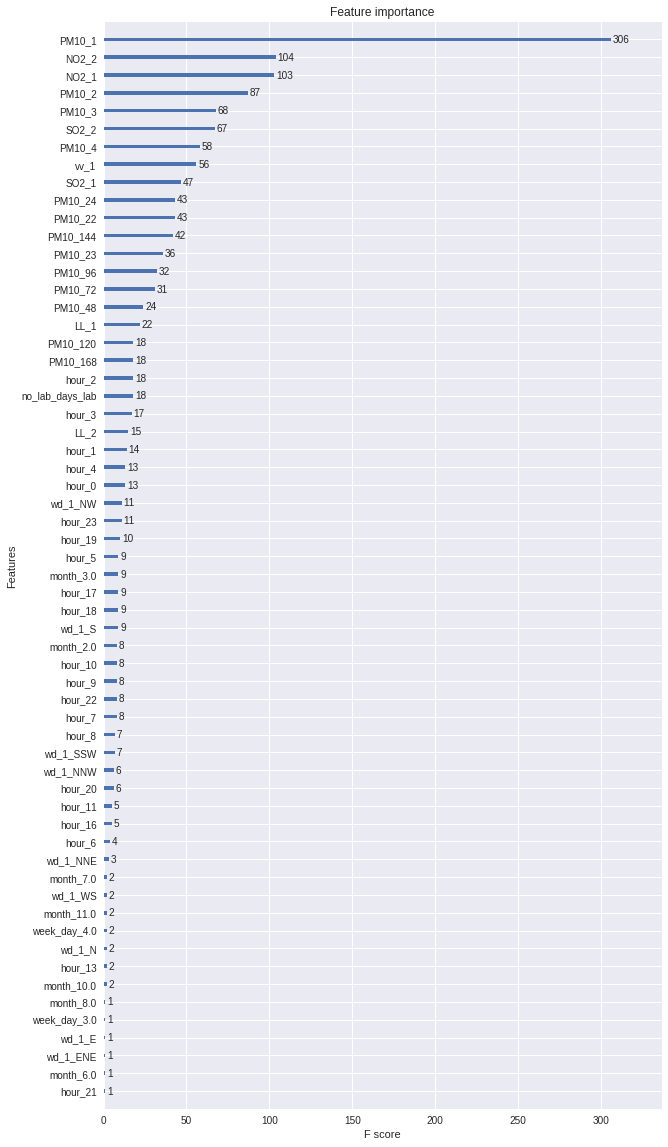

In [0]:
fig, ax = plt.subplots(figsize=(10, 20))
xgboost.plot_importance(regXGB, ax=ax)

importances scores explanation
https://datascience.stackexchange.com/questions/34209/xgboost-quantifying-feature-importances

In [0]:
plot_importance(regXGB)

NameError: ignored

In [0]:
regXGB.feature_importances_

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f2e6953eeb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


AttributeError: ignored

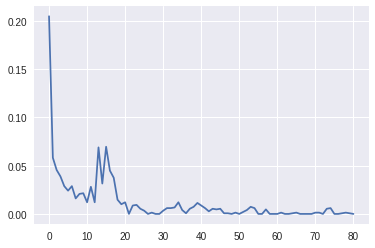

In [0]:
plot(regXGB.feature_importances_)

# PM10 forecasts 6 hours ahead
n_estimators=500, min_samples_leaf=10,max_depth=2, random_state=42

In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]

# We convert the 'hour' variable to string
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)

# We convert the 'week_day' variable to string
X_train.week_day = X_train.week_day.astype(str)
X_test.week_day = X_test.week_day.astype(str)

# We convert the 'month' variable to string
X_train.month = X_train.month.astype(str)
X_test.month = X_test.month.astype(str)

X_train = X_train[['PM10_7', 'PM10_8', 'PM10_9', 'PM10_10', 'PM10_22', 'PM10_23', 'PM10_24', 
                   'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 
                   'no_lab_days', 'hour', 'week_day', 'month']]
X_test = X_test[['PM10_7', 'PM10_8', 'PM10_9', 'PM10_10', 'PM10_22', 'PM10_23', 'PM10_24', 
                 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 
                 'no_lab_days', 'hour','week_day', 'month']]



X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)


# Al hacer el one hot encoding el X_train y el X_test tienen distintas dimensiones. X_train tiene 47 variables y X_test 44. Por que? Porque el dataset de test tiene solo 9 meses, de enero a septiembre, y entonces la variable month solo se convierte en 9 variables, mientras que el dataset tendriamos 12, los 12 meses del anho. 
# Con el siguiente codigo solucionamos el problema (falta referencia)

# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( X_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X_train.columns]
# This code also ensure that column resulting from category in the test dataset but not present in the training dataset will be removed



regXGB = XGBRegressor(n_estimators=500, min_samples_leaf=10,max_depth=2, random_state=42)
regXGB.fit(X_train,y_train)


# Compute train scores

y_pred = regXGB.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regXGB.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


R^2 train: 0.3783363410566375
R^2 adjusted train: 0.3769392899419598
Mean Absolute Error train: 7.981519507604723
Root Mean Squared Error train: 11.679267022942094
Standard Deviation train: PM10_0    14.812823
dtype: float64
R^2 test: 0.23909019501856432
R^2 adjusted test: 0.23211157884384526
Mean Absolute Error test: 6.95376437207906
Root Mean Squared Error test: 9.37674210874117
Standard Deviation test: PM10_0    10.749429
dtype: float64


# PM10 forecasts 6 hours ahead
### Gridsearchcv  
 "n_estimators":[100, 500, 1000, 2000],  
                                "min_samples_leaf":[10,30],  
                                  "max_depth":range(2,5)},  
                                    scoring="neg_mean_absolute_error")  


In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]

# We convert the 'hour' variable to string
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)

# We convert the 'week_day' variable to string
X_train.week_day = X_train.week_day.astype(str)
X_test.week_day = X_test.week_day.astype(str)

# We convert the 'month' variable to string
X_train.month = X_train.month.astype(str)
X_test.month = X_test.month.astype(str)

X_train = X_train[['PM10_7', 'PM10_8', 'PM10_9', 'PM10_10', 'PM10_22', 'PM10_23', 'PM10_24', 
                   'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 
                   'no_lab_days', 'hour', 'week_day', 'month']]
X_test = X_test[['PM10_7', 'PM10_8', 'PM10_9', 'PM10_10', 'PM10_22', 'PM10_23', 'PM10_24', 
                 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 
                 'no_lab_days', 'hour','week_day', 'month']]



X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)


# Al hacer el one hot encoding el X_train y el X_test tienen distintas dimensiones. X_train tiene 47 variables y X_test 44. Por que? Porque el dataset de test tiene solo 9 meses, de enero a septiembre, y entonces la variable month solo se convierte en 9 variables, mientras que el dataset tendriamos 12, los 12 meses del anho. 
# Con el siguiente codigo solucionamos el problema (falta referencia)

# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( X_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X_train.columns]
# This code also ensure that column resulting from category in the test dataset but not present in the training dataset will be removed



regXGB = GridSearchCV(XGBRegressor(n_estimators=350, min_samples_leaf=1,max_depth=4, random_state=42),
                   param_grid={"n_estimators":[100, 500, 1000, 2000],
                                "min_samples_leaf":[10,30],
                                  "max_depth":range(2,5)},
                                    scoring="neg_mean_absolute_error")

regXGB.fit(X_train,y_train)

print(regXGB.best_params_)
print("Best score: {}".format(regXGB.best_score_))


# Compute train scores

y_pred = regXGB.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regXGB.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 500}
Best score: -8.478115268402753
R^2 train: 0.3783363410566375
R^2 adjusted train: 0.3769392899419598
Mean Absolute Error train: 7.981519507604723
Root Mean Squared Error train: 11.679267022942094
Standard Deviation train: PM10_0    14.812823
dtype: float64
R^2 test: 0.23909019501856432
R^2 adjusted test: 0.23211157884384526
Mean Absolute Error test: 6.95376437207906
Root Mean Squared Error test: 9.37674210874117
Standard Deviation test: PM10_0    10.749429
dtype: float64


# PM10 forecasts 12 hours ahead

In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]

# We convert the 'hour' variable to string
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)

# We convert the 'week_day' variable to string
X_train.week_day = X_train.week_day.astype(str)
X_test.week_day = X_test.week_day.astype(str)

# We convert the 'month' variable to string
X_train.month = X_train.month.astype(str)
X_test.month = X_test.month.astype(str)

X_train = X_train[['PM10_13', 'PM10_14', 'PM10_15', 'PM10_16', 'PM10_22', 'PM10_23', 'PM10_24',
                   'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 
                   'no_lab_days', 'hour', 'week_day', 'month']]

X_test = X_test[['PM10_13', 'PM10_14', 'PM10_15', 'PM10_16', 'PM10_22', 'PM10_23', 'PM10_24',
                   'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 
                   'no_lab_days', 'hour', 'week_day', 'month']]



X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)


# Al hacer el one hot encoding el X_train y el X_test tienen distintas dimensiones. X_train tiene 47 variables y X_test 44. Por que? Porque el dataset de test tiene solo 9 meses, de enero a septiembre, y entonces la variable month solo se convierte en 9 variables, mientras que el dataset tendriamos 12, los 12 meses del anho. 
# Con el siguiente codigo solucionamos el problema (falta referencia)

# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( X_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X_train.columns]
# This code also ensure that column resulting from category in the test dataset but not present in the training dataset will be removed



regXGB = XGBRegressor(n_estimators=500, min_samples_leaf=10,max_depth=2, random_state=42)
regXGB.fit(X_train,y_train)


# Compute train scores

y_pred = regXGB.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regXGB.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


R^2 train: 0.32041246662544254
R^2 adjusted train: 0.31888524445737243
Mean Absolute Error train: 8.438354825714354
Root Mean Squared Error train: 12.211262000309592
Standard Deviation train: PM10_0    14.812823
dtype: float64
R^2 test: 0.1604743825300825
R^2 adjusted test: 0.15277474846726546
Mean Absolute Error test: 7.412786393608017
Root Mean Squared Error test: 9.849231782931415
Standard Deviation test: PM10_0    10.749429
dtype: float64


# PM10 forecasts 24 hours ahead

In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]

# We convert the 'hour' variable to string
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)

# We convert the 'week_day' variable to string
X_train.week_day = X_train.week_day.astype(str)
X_test.week_day = X_test.week_day.astype(str)

# We convert the 'month' variable to string
X_train.month = X_train.month.astype(str)
X_test.month = X_test.month.astype(str)

X_train = X_train[['PM10_25', 'PM10_26', 'PM10_27', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days', 'hour','week_day', 'month']]
X_test = X_test[['PM10_25', 'PM10_26', 'PM10_27', 'PM10_48', 'PM10_72', 'PM10_96', 'PM10_120', 'PM10_144', 'PM10_168', 'no_lab_days', 'hour', 'week_day', 'month']]



X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)


# Al hacer el one hot encoding el X_train y el X_test tienen distintas dimensiones. X_train tiene 47 variables y X_test 44. Por que? Porque el dataset de test tiene solo 9 meses, de enero a septiembre, y entonces la variable month solo se convierte en 9 variables, mientras que el dataset tendriamos 12, los 12 meses del anho. 
# Con el siguiente codigo solucionamos el problema (falta referencia)

# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( X_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X_train.columns]
# This code also ensure that column resulting from category in the test dataset but not present in the training dataset will be removed



regXGB = XGBRegressor(n_estimators=500, min_samples_leaf=10,max_depth=2, random_state=42)
regXGB.fit(X_train,y_train)


# Compute train scores

y_pred = regXGB.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regXGB.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


R^2 train: 0.2756720236313138
R^2 adjusted train: 0.2741567518409791
Mean Absolute Error train: 8.774617302203806
Root Mean Squared Error train: 12.60681783772796
Standard Deviation train: PM10_0    14.812823
dtype: float64
R^2 test: 0.07826190549658962
R^2 adjusted test: 0.0703962517192217
Mean Absolute Error test: 7.881427475078497
Root Mean Squared Error test: 10.320224620628093
Standard Deviation test: PM10_0    10.749429
dtype: float64


In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]

# We convert the 'hour' variable to string
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)

# We convert the 'week_day' variable to string
X_train.week_day = X_train.week_day.astype(str)
X_test.week_day = X_test.week_day.astype(str)

# We convert the 'month' variable to string
X_train.month = X_train.month.astype(str)
X_test.month = X_test.month.astype(str)


X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)


# Al hacer el one hot encoding el X_train y el X_test tienen distintas dimensiones. X_train tiene 47 variables y X_test 44. Por que? Porque el dataset de test tiene solo 9 meses, de enero a septiembre, y entonces la variable month solo se convierte en 9 variables, mientras que el dataset tendriamos 12, los 12 meses del anho. 
# Con el siguiente codigo solucionamos el problema (falta referencia)

# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( X_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X_train.columns]
# This code also ensure that column resulting from category in the test dataset but not present in the training dataset will be removed



regXGB = XGBRegressor(n_estimators=500, min_samples_leaf=10,max_depth=2, random_state=42)
regXGB.fit(X_train,y_train)


# Compute train scores

y_pred = regXGB.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regXGB.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  

R^2 train: 0.693806737178493
R^2 adjusted train: 0.6923079472668536
Mean Absolute Error train: 5.3003355651592825
Root Mean Squared Error train: 8.19663626189891
Standard Deviation train: PM10_0    14.812823
dtype: float64
R^2 test: 0.6134122295461306
R^2 adjusted test: 0.6056260947831531
Mean Absolute Error test: 4.747758221720315
Root Mean Squared Error test: 6.683584405600813
Standard Deviation test: PM10_0    10.749429
dtype: float64


#### XGBOOST

All variables

In [0]:
X_train = pyreadr.read_r("X_train_PM10_201401_201612_multivar.rds")
y_train = pyreadr.read_r("y_train_PM10_201401_201612_multivar.rds")

X_test = pyreadr.read_r("X_test_PM10_201701_201709_multivar.rds")
y_test = pyreadr.read_r("y_test_PM10_201701_201709_multivar.rds")

X_train = X_train[None]
y_train = y_train[None]
X_test = X_test[None]
y_test = y_test[None]

# We convert the 'hour' variable to string
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)

# We convert the 'week_day' variable to string
X_train.week_day = X_train.week_day.astype(str)
X_test.week_day = X_test.week_day.astype(str)

# We convert the 'month' variable to string
X_train.month = X_train.month.astype(str)
X_test.month = X_test.month.astype(str)


X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)


# Al hacer el one hot encoding el X_train y el X_test tienen distintas dimensiones. X_train tiene 47 variables y X_test 44. Por que? Porque el dataset de test tiene solo 9 meses, de enero a septiembre, y entonces la variable month solo se convierte en 9 variables, mientras que el dataset tendriamos 12, los 12 meses del anho. 
# Con el siguiente codigo solucionamos el problema (falta referencia)

# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( X_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X_train.columns]
# This code also ensure that column resulting from category in the test dataset but not present in the training dataset will be removed



regXGB = XGBRegressor(n_estimators=500, min_samples_leaf=10,max_depth=2, random_state=42)
regXGB.fit(X_train,y_train)


# Compute train scores

y_pred = regXGB.predict(X_train)

r2_train = r2_score(y_train, y_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mae_train = mean_absolute_error(y_train, y_pred)
r2_adjusted_train = 1 - (1-r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
sd_train = std(y_train)

print("R^2 train: {}".format(r2_train))
print("R^2 adjusted train: {}".format(r2_adjusted_train))
print("Mean Absolute Error train: {}".format(mae_train))
print("Root Mean Squared Error train: {}".format(rmse_train)) 
print("Standard Deviation train: {}".format(sd_train))  

# Compute test scores

y_pred = regXGB.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_adjusted_test = 1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
sd_test = std(y_test)

print("R^2 test: {}".format(r2_test))
print("R^2 adjusted test: {}".format(r2_adjusted_test))
print("Mean Absolute Error test: {}".format(mae_test))
print("Root Mean Squared Error test: {}".format(rmse_test))
print("Standard Deviation test: {}".format(sd_test))  


R^2 train: 0.693806737178493
R^2 adjusted train: 0.6923079472668536
Mean Absolute Error train: 5.3003355651592825
Root Mean Squared Error train: 8.19663626189891
Standard Deviation train: PM10_0    14.812823
dtype: float64
R^2 test: 0.6134122295461306
R^2 adjusted test: 0.6056260947831531
Mean Absolute Error test: 4.747758221720315
Root Mean Squared Error test: 6.683584405600813
Standard Deviation test: PM10_0    10.749429
dtype: float64



# **Mejores resultados antes de este notebook**
Resultados XGBoost con los siguientes parametros (y con hour, month y weekday)

regXGB = GridSearchCV(XGBRegressor(n_estimators=100, min_samples_leaf=1,max_depth=4),
                   param_grid={"min_samples_leaf":[10,20,30,40,70,100],
                              "max_depth":range(2,10)},
                   scoring="neg_mean_squared_error")
                   
  Mejores parametros {'max_depth': 3, 'min_samples_leaf': 10}
  
  Train
  
R2 = 0.6500857644451381
rmse =  8.861409992242404

 Test
  
R2 = 0.6122589338516852
rmse =  6.804600716948688

Es el mejor R2 que he obtenido hasta ahora. Pero todavía se me antoja muy bajo. Y sobre todo un rmse muy alto. 
                   
                   
Si subimos los n estimators a 350 mejora un poco el resultado en test, a partir de ahi empieza a empeorar (overfitting). Pendiente hacer un grafico con la evolucion del R2 segun vamos variando el numero de estimators.

Esto lo he hecho con los mejores parametros elegidos por gridsearchcv. Habria que combinar las tres variables en un gridsearch?
 

**Resultados de este notebook**

Me quedo con xgboost. 
Incluir variables lagged de no2 y so2 para mejorar el modelo de pm10

Pues obtengo peores resultados

Resultados en train

0.6999916104541364

0.6993441272715504

8.199388923966012

Resultados en test

0.6064956206343766

0.6031155267931912

6.862638536821753


Incluyo tambien los niveles del O3. Mejora un poquito, muy poco.

En este caso en train sube

0.7105443286766205

0.7098740820279518

8.053892316950074


Test

0.6082040880935934

0.604591655088049

6.84772466415434

Al introducir la variable lab (sin o3 )tampoco se mueve mucho

Train

0.7010470857165632

0.7003784709431913

8.184354312220824

Test

0.6053976949516295

0.6018925786375019

6.867154043380078

### Al incluir la variable vv (fuerza viento) el modelo mejora un poco

Train

0.7075842640028696

0.7068842655766931

8.094376414198711

Test

0.6152870917971485

0.6116277299695523

6.780556822850893

### Al incluir la variable wd (direcci'on viento) el modelo mejora otro poco (mas en train que en test)

Train

0.7115234312666878

0.7101047684650643

8.039671399926052

Test

0.6194624718864719

0.6119703958092643

6.743660947199181

### Incluimos el valor de pm10 de una hora menos de la estacion Argentina, mas proxima a los focos de contaminacion industrial
Mejora un poco mas

Train

0.718860331470167

0.7174579165592537

7.93632092440623

Test

0.6204075122922108

0.6128144572912294

6.731793806147569

### Al incluir el pm25 t-1 empeoramos el modelo

0.7158746433859251
0.7144418889570989
7.984338653641078

0.6147745549714891
0.6070051994817923
6.781618222268876

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
with open('/content/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/gdrive/My\ Drive/foo.txt

Hello Google Drive!

In [0]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


We upload the train and test data

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving X_test_201701_201709.csv to X_test_201701_201709.csv
Saving y_test_201701_201709.csv to y_test_201701_201709.csv
Saving X_train_2014_2016.csv to X_train_2014_2016.csv
Saving y_train_2014_2016.csv to y_train_2014_2016.csv
User uploaded file "X_test_201701_201709.csv" with length 513161 bytes
User uploaded file "y_test_201701_201709.csv" with length 18546 bytes
User uploaded file "X_train_2014_2016.csv" with length 2025029 bytes
User uploaded file "y_train_2014_2016.csv" with length 73801 bytes


In [0]:
!ls

gdrive	     X_test_201701_201709_6h.csv  y_test_201701_201709_6h.csv
sample_data  X_train_2014_2016_6h.csv	  y_train_2014_2016_6h.csv


In [0]:
 !rm *.csv*

rm: cannot remove '*.csv*': No such file or directory


In [0]:
#X_train = pd.read_csv("X_train_lite.csv")
#y_train = pd.read_csv("y_train_lite.csv")

X_train = pd.read_csv("X_train_2014_2016.csv")
y_train = pd.read_csv("y_train_2014_2016.csv")

#X_train = pd.read_csv("X_train_2009_2016.csv")
#y_train = pd.read_csv("y_train_2009_2016.csv")

X_test = pd.read_csv("X_test_201701_201709.csv")
y_test = pd.read_csv("y_test_201701_201709.csv")

#X_test = pd.read_csv("X_test.csv")
#y_test = pd.read_csv("y_test.csv")

In [0]:
X_train.head()

,PM10_1_arg,hour,week_day,month,lab,PM10_1,PM10_2,PM10_3,PM10_4,NO2_1,...,SO2_4,vv_1,vv_2,vv_3,vv_4,wd_1,wd_2,wd_3,wd_4,PM25_1
0,18,4,3,1,no_lab,21,16,20,22,29,...,2,0.11,0.10,0.17,0.23,SSW,SSE,WS,S,17
1,19,5,3,1,no_lab,14,21,16,20,20,...,3,0.10,0.11,0.10,0.17,SE,SSW,SSE,WS,10
2,15,6,3,1,no_lab,14,14,21,16,23,...,2,0.11,0.10,0.11,0.10,SW,SE,SSW,SSE,16
3,9,7,3,1,no_lab,12,14,14,21,23,...,2,0.10,0.11,0.10,0.11,SSW,SW,SE,SSW,17
4,8,8,3,1,no_lab,9,12,14,14,20,...,2,0.91,0.10,0.11,0.10,SE,SSW,SW,SE,16


In [0]:
X_test.head()

,PM10_1_arg,hour,week_day,month,lab,PM10_1,PM10_2,PM10_3,PM10_4,NO2_1,...,SO2_4,vv_1,vv_2,vv_3,vv_4,wd_1,wd_2,wd_3,wd_4,PM25_1
0,42,4,7,1,no_lab,36,35,38,46,40,...,3,0.10,0.11,0.11,0.10,WNW,W,W,SSW,24
1,42,5,7,1,no_lab,31,36,35,38,39,...,3,0.11,0.10,0.11,0.11,W,WNW,W,W,32
2,38,6,7,1,no_lab,22,31,36,35,37,...,5,0.12,0.11,0.10,0.11,WNW,W,WNW,W,21
3,41,7,7,1,no_lab,32,22,31,36,40,...,7,0.11,0.12,0.11,0.10,WNW,WNW,W,WNW,29
4,46,8,7,1,no_lab,21,32,22,31,38,...,8,0.10,0.11,0.12,0.11,NW,WNW,WNW,W,29


Convertimos a strings las variables hour, week_day y month

In [0]:
X_train.hour = X_train.hour.astype(str)
X_test.hour = X_test.hour.astype(str)


X_train.week_day = X_train.week_day.astype(str)
X_test.week_day = X_test.week_day.astype(str)

X_train.month = X_train.month.astype(str)
X_test.month = X_test.month.astype(str)

One hot encoding

In [0]:
X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)

In [0]:
X_train.info(null_counts=True, verbose=True)

In [0]:
X_train.shape

(25544, 125)

In [0]:
X_test.shape

(6475, 122)

Al hacer el one hot encoding el X_train y el X_test tienen distintas dimensiones. X_train tiene 47 variables y X_test 44. Por que? Porque el dataset de test tiene solo 9 meses, de enero a septiembre, y entonces la variable month solo se convierte en 9 variables, mientras que el dataset tendriamos 12, los 12 meses del anho. 
Con el siguiente codigo solucionamos el problema (falta referencia)

In [0]:
# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( X_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X_train.columns]
# This code also ensure that column resulting from category in the test dataset but not present in the training dataset will be removed

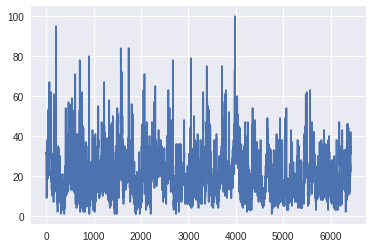

In [0]:
plt.plot(y_test["PM10_0"]);

Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



XGBoost

In [0]:
from xgboost import XGBRegressor
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#regXGB = GridSearchCV(XGBRegressor(n_estimators=100, min_samples_leaf=1,max_depth=4),
 #                  param_grid={"min_samples_leaf":[10,20,30,40,70,100],
  #                            "max_depth":range(2,10)},
   #                scoring="neg_mean_squared_error")

regXGB = XGBRegressor(n_estimators=350, min_samples_leaf=10,max_depth=3)

regXGB.fit(X_train,y_train)

#print(regXGB.best_params_)
#print(regXGB.best_score_)
#print(np.sqrt(-regXGB.best_score_))
#print(mean_absolute_error(y_test, y_pred))


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, min_samples_leaf=10, missing=None,
       n_estimators=350, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [0]:
# Evaluacion con train

y_pred = regXGB.predict(X_train)
r2 = r2_score(y_train, y_pred)
print(r2)
r2_adjusted = 1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print(r2_adjusted)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(rmse)

0.7158746433859251
0.7144418889570989
7.984338653641078


In [0]:
# Evaluacion con test
y_pred = regXGB.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)
r2_adjusted = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print(r2_adjusted)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

0.6147745549714891
0.6070051994817923
6.781618222268876


In [0]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
regXGB = GridSearchCV(XGBRegressor(n_estimators=350, min_samples_leaf=1,max_depth=4),
                   param_grid={"n_estimators":[100, 200, 300, 400, 500, 1000],
                                "min_samples_leaf":[10,20,30,40,70,100],
                                  "max_depth":range(2,10)},
                                    scoring="neg_mean_squared_error")

regXGB.fit(X_train,y_train)

print(regXGB.best_params_)
print(regXGB.best_score_)
print(np.sqrt(-regXGB.best_score_))
print(mean_absolute_error(y_test, y_pred))


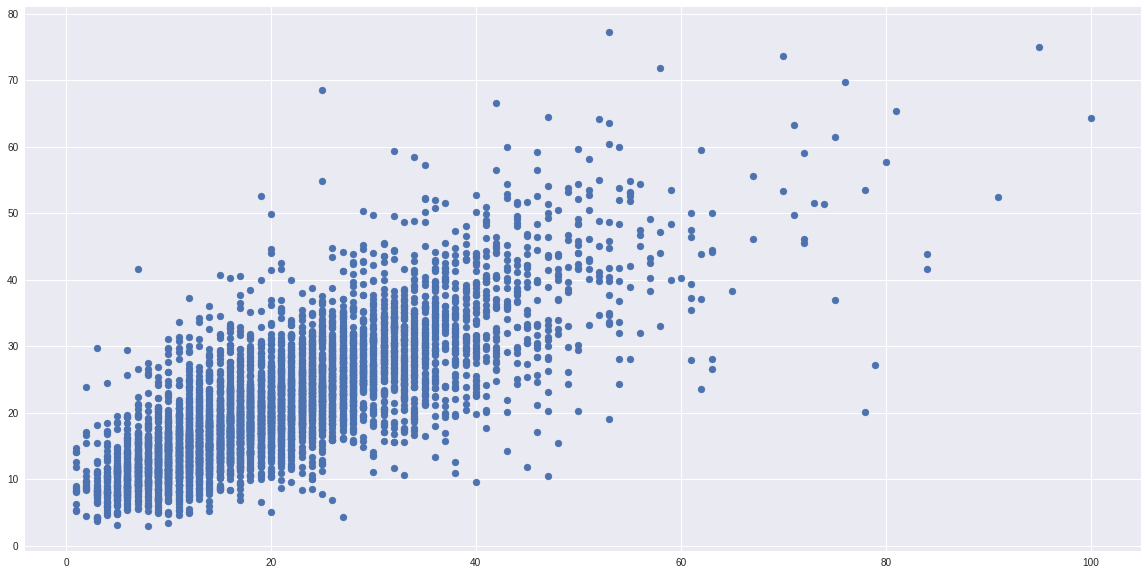

In [0]:
y_pred = y_pred.astype(float)
y_test = pd.DataFrame(y_test)
y_test = y_test.values
y_pred = pd.DataFrame(y_pred)
plt.figure(figsize=(20,10))
plt.scatter(x = y_test, y = y_pred)